In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

import cv2 
from glob import glob
import os

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to enco

In [2]:
# see the version of tensorflow
print(tf.__version__)

2.15.0


In [3]:
main_path = "d:/Study Materials/4-2/paint like any painter/Image_data/monet_jpg/"
style_img_paths = []
for path in glob(main_path + '*.jpg'):
    style_img_paths.append(path)
    
print("There are {} style images in Van Gogh Paintings Dataset".format(len(style_img_paths)))

There are 300 style images in Van Gogh Paintings Dataset


In [4]:
main_path = "d:/Study Materials/4-2/paint like any painter/Image_data/photo_jpg/"
normal_image_paths = []
for path in glob(main_path + '*.jpg'):
    normal_image_paths.append(path)
    
print("There are {} normal images in Van Gogh Paintings Dataset".format(len(normal_image_paths)))

There are 252 normal images in Van Gogh Paintings Dataset


In [5]:
style_images = []
normal_images = []

for style_path in style_img_paths:
    img = cv2.imread(style_path)
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    style_images.append(img)
    
for normal_path in normal_image_paths:
    img = cv2.imread(normal_path)
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    normal_images.append(img)
    
print(len(style_images))
print(len(normal_images))

300
252


In [6]:
# converting to float32 
style_images = np.array(style_images,dtype=np.float32)
normal_images = np.array(normal_images,dtype=np.float32)

# scaling between -1 and 1
style_images = style_images / 255.5 - 1
normal_images = normal_images / 255.5 - 1

# batching
style_images = tf.data.Dataset.from_tensor_slices(style_images).batch(1)
normal_images = tf.data.Dataset.from_tensor_slices(normal_images).batch(1)

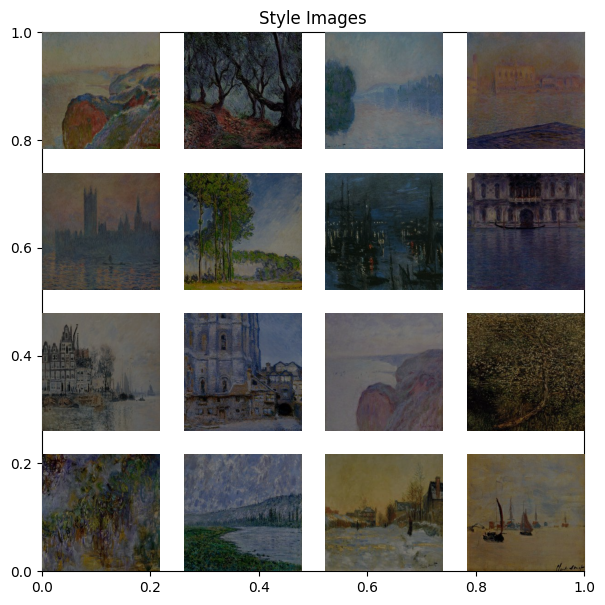

In [7]:
plt.figure(figsize=(7,7))
plt.title("Style Images")
for i,image in enumerate(style_images.take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0]*0.5+0.5)
    plt.axis('off')
plt.show()

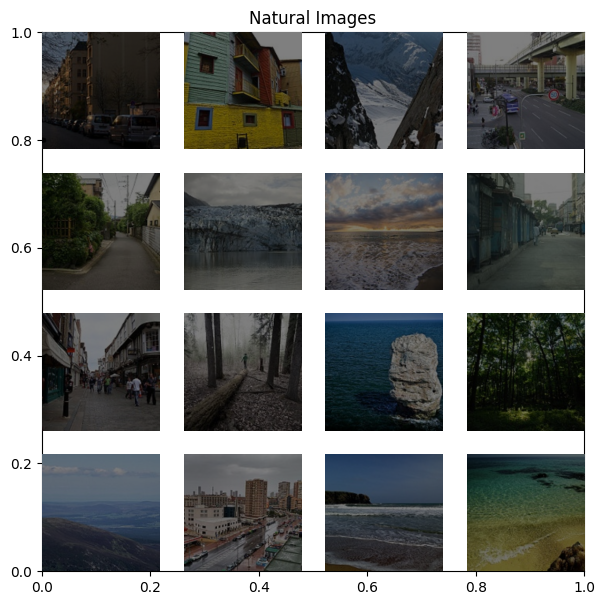

In [8]:
plt.figure(figsize=(7,7))
plt.title("Natural Images")
for i,image in enumerate(normal_images.take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image[0]*0.5+0.5)
    plt.axis('off')
plt.show()

In [9]:
# we need to downsample and upsample the images, so let's write two new layers, Upsample layer and Downsample Layer
OUTPUT_CHANNELS = len(["Red","Green","Blue"])

def downsample(filters,size,apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    return result

In [10]:

def Generator():
    inputs = layers.Input([256,256,3])
    
    # downsample so that we can use skip connections
    down_stack = [downsample(64,4,apply_instancenorm=False), # 128x128x64
                    downsample(128,4), # 64x64x128
                    downsample(256,4), # 32x32x256
                    downsample(512,4), # 16x16x512
                    downsample(512,4), # 8x8x512
                    downsample(512,4), # 4x4x512
                    downsample(512,4), # 2x2x512
                    downsample(512,4), # 1x1x512
                    ]
    
    up_stack = [upsample(512,4,apply_dropout=True), # 2x2
                upsample(512,4,apply_dropout=True), # 4x4
                upsample(512,4), # 8x8
                upsample(256,4), # 16x16
                upsample(128,4), # 32x32
                upsample(64,4), # 64x64
                upsample(3,4), # 128x128
               ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    
    # we'll create skip connections like a residual network
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs,outputs=x)

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
    
    inp = layers.Input([256,256,3],name="input_image")
    
    x = inp
    
    down1 = downsample(64,4,False)(x) # 128x128x64
    down2 = downsample(128,4)(down1) # 64x64x128
    
    zero_pad1 = layers.ZeroPadding2D()(down2)
    
    conv = layers.Conv2D(256,4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1) # 31x31x256
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=inp,outputs=last)

In [12]:
class CycleGAN(keras.Model):
    
    def __init__(self,vangogh_generator,photo_generator,vangogh_discriminator,photo_discriminator,lambda_cycle = 10):
        super(CycleGAN,self).__init__()
        self.v_gen = vangogh_generator
        self.p_gen = photo_generator
        self.v_disc = vangogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    
    def compile(self,v_gen_optimizer,p_gen_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,
                identity_loss_fn,v_disc_optimizer):
        super(CycleGAN,self).compile()
        self.v_gen_optimizer = v_gen_optimizer
        self.p_gen_optimizer =  p_gen_optimizer
        self.v_disc_optimizer  = v_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.p_disc_optimizer = p_disc_optimizer
        
    
    def train_step(self,batch_data):
        real_vangogh,real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to vangogh back to photo
            fake_vangogh = self.v_gen(real_photo,training=True)
            cycled_photo = self.p_gen(fake_vangogh,training=True)
            
            # vangogh to photo back to vangogh
            fake_photo = self.p_gen(real_vangogh,training=True)
            cycled_vangogh = self.v_gen(fake_photo,training=True)
            
            # generating itself
            same_photo = self.p_gen(real_photo,training=True)
            same_vangogh = self.v_gen(real_vangogh,training=True)
            
            # checking images using discriminator
            disc_real_vangogh = self.v_disc(real_vangogh,training=True)
            disc_real_photo = self.p_disc(real_photo,training=True)
            
            disc_fake_vangogh = self.v_disc(fake_vangogh,training=True)
            disc_fake_photo = self.p_disc(fake_photo,training=True)
            
            # computing generator loss
            vangogh_gen_loss = self.gen_loss_fn(disc_fake_vangogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # computing total cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_vangogh,cycled_vangogh,self.lambda_cycle) + self.cycle_loss_fn(real_photo,cycled_photo,self.lambda_cycle)
            
            # computing total loss
            total_vangogh_gen_loss = vangogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vangogh, same_vangogh, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # computing discriminator loss
            vangogh_disc_loss = self.disc_loss_fn(disc_real_vangogh,disc_fake_vangogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo,disc_fake_photo)
            
        
        # calculating gradients of networks
        vangogh_generator_gradients = tape.gradient(total_vangogh_gen_loss,self.v_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
        
        vangogh_discriminator_gradients = tape.gradient(vangogh_disc_loss,self.v_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)
        
        self.v_gen_optimizer.apply_gradients(zip(vangogh_generator_gradients,self.v_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        
        self.v_disc_optimizer.apply_gradients(zip(vangogh_discriminator_gradients,self.v_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
        
        return {
            "v_gen_loss": total_vangogh_gen_loss,
            "p_gen_loss": total_photo_gen_loss,
            "v_disc_loss": vangogh_disc_loss,
            "p_disc_loss": photo_disc_loss
        }

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
def discriminator_loss(real,generated):
    
    real_loss = cross_entropy(tf.ones_like(real),real)
    generated_loss = cross_entropy(tf.zeros_like(generated),generated)
    
    total_loss = real_loss + generated_loss
    
    return total_loss * 0.5

In [14]:
def generator_loss(generated):
    
    return cross_entropy(tf.ones_like(generated),generated)

In [15]:
def cycle_loss(real_image,cycled_image,LAMBDA):
    
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

def identity_loss(real_image,same_image,LAMBDA):
    
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA

In [16]:
# We'll use Adam optimizer
vangogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

vangogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
vangogh_generator = Generator() # generates van gogh paintings using natural images
photo_generator = Generator() # generates natural images using van gogh paintings

vangogh_discriminator = Discriminator() # determines whether van gogh painting is real or generated
photo_discriminator = Discriminator() # determines whether natural image is real or generated

In [18]:
model = CycleGAN(vangogh_generator=vangogh_generator,
                photo_generator=photo_generator,
                vangogh_discriminator=vangogh_discriminator,
                photo_discriminator=photo_discriminator
                )

model.compile(v_gen_optimizer=vangogh_generator_optimizer,
              p_gen_optimizer=photo_generator_optimizer,
              p_disc_optimizer=photo_discriminator_optimizer,
              v_disc_optimizer=vangogh_discriminator_optimizer,
              gen_loss_fn=generator_loss,
              disc_loss_fn=discriminator_loss,
              cycle_loss_fn=cycle_loss,
              identity_loss_fn=identity_loss
             )

In [19]:
model.fit(tf.data.Dataset.zip((style_images,normal_images)),epochs=2) 

model.save_weights("model.h5")

Epoch 1/2
252/252 [==============================] - 643s 2s/step - v_gen_loss: 5.2104 - p_gen_loss: 5.2651 - v_disc_loss: 0.5322 - p_disc_loss: 0.5447
Epoch 2/2
252/252 [==============================] - 642s 3s/step - v_gen_loss: 3.4926 - p_gen_loss: 3.4134 - v_disc_loss: 0.5522 - p_disc_loss: 0.5438


FileNotFoundError: [Errno 2] No such file or directory: 'd:/Study Materials/4-2/paint like any painter/generated_images//{i}.png'

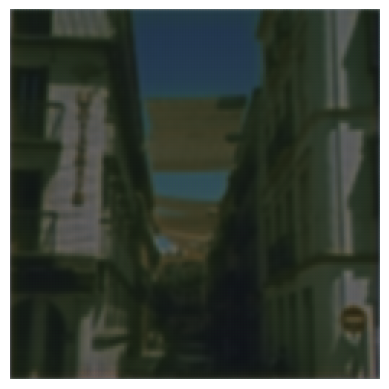

In [21]:

from rembg import remove 
from PIL import Image 
if not os.path.exists("generated_images"):
    os.makedirs("generated_images")

for i,img in enumerate(normal_images.take(252)):
    prediction = vangogh_generator(img,training=False)[0].numpy()
    # only show the generated image
    plt.imshow(prediction*0.5+0.5)
    plt.axis('off')
    plt.savefig(f"generated_images/{i}.png")



In [32]:
cycle_gan = "d:/Study Materials/4-2/paint like any painter/generated_images"
for i in range(252):
    filename = cycle_gan + "/" + str(i) + ".png"
    jpg_filename = cycle_gan + "/" + str(i) + ".jpg"
    input = Image.open(filename)
    cgan = remove(input)
    input = input.convert("RGB")
    input.save(jpg_filename)

d:\Study Materials\4-2\paint like any painter
d:/Study Materials/4-2/paint like any painter/generated_images
